## 의사결정트리 
  - 루트노드를 기준으로 규칙노드의 조건을 거쳐 리프노드(분류값)로 분할됨
  - 새로운 규칙을 만들때마다 분류를 가짐
  - 브랜치/서브트리 : 새로운 규칙 조건마다 규칙노드 기반의 서브트리 생성
  - 데이터셋에 피쳐가 있고 피처가 결합하여 규칙조건을 만들 때마다 규칙 노드가 만들어짐.
  - 하지만 규칙이 많다 -> 분류 결정하는 방식이 복잡 -> 과적합 발생

정보의 균일도를 측정하는 방법은 엔트로피를 이용한 정보이득 지수와 지니 계수가 있다.
  - 엔트로피를 이용한 정보이득 : 엔트로피는 주어진 데이터 집합의 혼잡도를 의미
    - 서로 다른 값이 섞여 있으면 엔트로피가 높고, 같은값이 많으면 낮다.
    - 정보이득 지수는 1-엔트로피 지수. 결정트리는 정보이득 지수로 분할 기준을 결정
    - 정보이득이 높은 속성을 기준으로 분할
  - 지니계수 : 경제학에서 불평등 지수를 나타낼때 사용하는 계수.
    - 0이 가장 평등하고 1에 가까울 수록 불평등. 머신러닝에 적용될때는 지니계수가 낮을수도 데이터 균일도가 높다는 것으로 해석.


- 결정트리에서 사용하는 파라미터명 (random Forest랑 혼용가능)
  - min_sample_split : 노드를 분할 하기위한 최소한의 샘플 데이터 수 디폴트는 2 작게 설정할수록 노드 많아져 과적합 가능성 증가
  - min_sample_leaf : 말단 노드가 되기 위한 최소한의 샘플 데이터 수
  - max_features : 최적의 분할을 위해 고려할 최대 피쳐 갯수 디폴트 None,
  데이터세트의 모든피처를 사용해 분할
  - max_depth : 최대 깊이를 설정 디폴트는 None이다. None이면 계속 깊이를 증가 시킴 깊이가 너무 깊어지면 최대분할하여 과적합이 일어날수있어 조절이 필요

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)

# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data,
                                                    iris_data.target,
                                                    test_size=0.2,
                                                    random_state=11)
# DecisionTreeClassfier학습.
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [5]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함.
export_graphviz(dt_clf, out_file= "tree.dot", #바로 출력안되고 .dot 파일로 저장됨
                class_names =iris_data.target_names, 
                feature_names = iris_data.feature_names,
                impurity = True,
                filled = True)

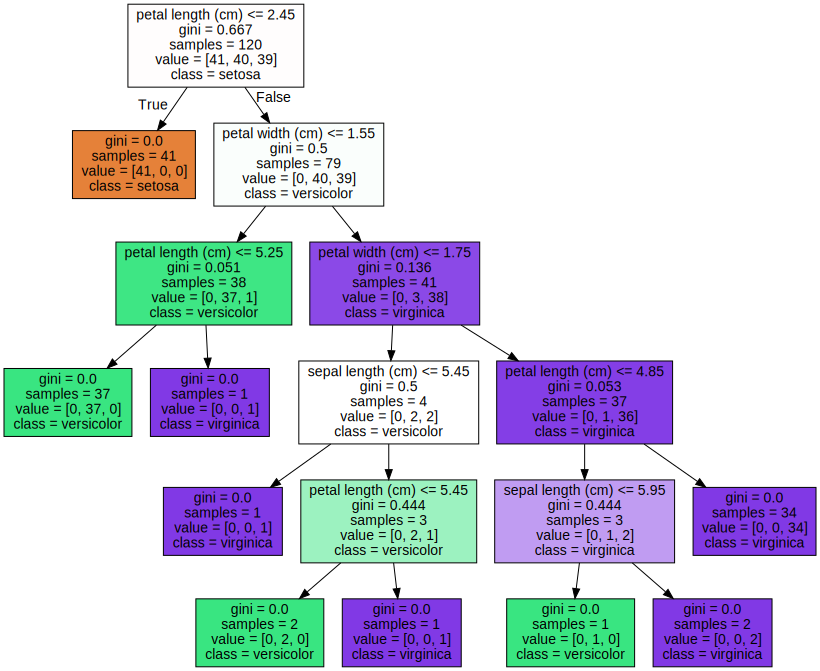

In [8]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz로 읽어서 Jupyter Notebook 상에서 시각화
with open('tree.dot') as f:  # f란이름으로 선언
  dot_graph = f.read()
graphviz.Source(dot_graph)
# value 값이 혼잡하면 gini 높아짐
# class는 value값이 가장 높은 값 출력
# 조건 == 첫줄

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred_test = dt_clf.predict(X_test)

In [10]:
confusion_matrix(pred_test, y_test)

array([[ 9,  0,  0],
       [ 0, 10,  2],
       [ 0,  0,  9]])

In [11]:
accuracy_score(pred_test,y_test)

0.9333333333333333

Feature importances:
[0.025 0.    0.555 0.42 ]
sepal length (cm) : 0.025
sepal width (cm) : 0.000
petal length (cm) : 0.555
petal width (cm) : 0.420


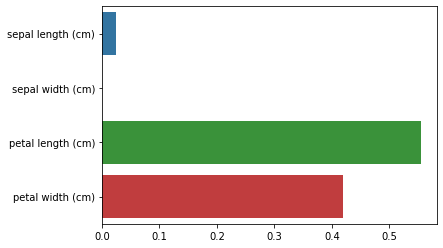

In [13]:
import seaborn as sns
import numpy as np

# feature importance 추출 <- 특성별 중요도를 출력
print('Feature importances:\n{0}'.format(np.round(dt_clf.feature_importances_,3)))

# feature별 umportance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
  print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

In [15]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

dtree = DecisionTreeClassifier()

### parameter 들을 dict형태로 설정 -> 횟수 설정
parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}
# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold로 나누어서 테스트 수행
## refit=True가 defult임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.
grid_dtree = GridSearchCV(dtree, param_grid = parameters, cv=3, refit=True)

# 붓꽃 Train 데이터로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가
grid_dtree.fit(X_train, y_train)

#GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[['params','mean_test_score',
           'rank_test_score', 'split0_test_score',
           'split1_test_score','split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.675000,5,0.675,0.675,0.675
1,"{'max_depth': 1, 'min_samples_split': 3}",0.675000,5,0.675,0.675,0.675
2,"{'max_depth': 2, 'min_samples_split': 2}",0.958333,3,0.925,1.000,0.950
3,"{'max_depth': 2, 'min_samples_split': 3}",0.958333,3,0.925,1.000,0.950
4,"{'max_depth': 3, 'min_samples_split': 2}",0.966667,1,0.925,1.000,0.975
5,"{'max_depth': 3, 'min_samples_split': 3}",0.966667,1,0.925,1.000,0.975


In [17]:
# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
estimator = grid_dtree.best_estimator_

In [19]:
from sklearn.tree import export_graphviz
# export_grathviz의 호출 결과로 out_file로 저장된 tree.dot 파일을 생성함.
export_graphviz(estimator, out_file= "best_tree.dot",
                class_names =iris_data.target_names, 
                feature_names = iris_data.feature_names,
                impurity = True,
                filled = True)

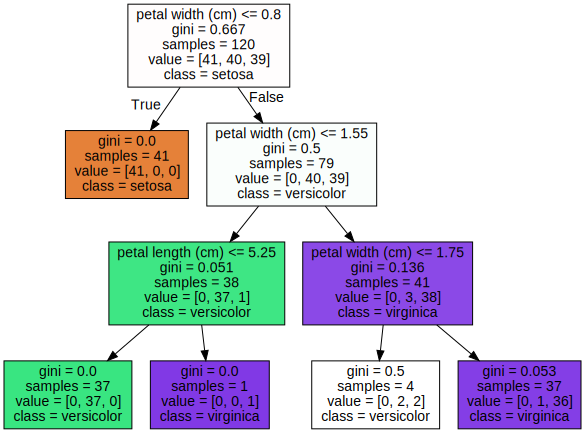

In [20]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz로 읽어서 Jupyter Notebook 상에서 시각화
with open('best_tree.dot') as f: 
  dot_graph = f.read()
graphviz.Source(dot_graph)